In [1]:
import os
_FINAL_DFS_DIR = os.path.join('..', '..', 'final_dfs')

import sys
sys.path.append('..')


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
from scipy import stats
import pandas as pd
import numpy as np

In [3]:
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]
df['method_name'].unique()

array(['LinearRegression', 'Shuffle_LinearRegression',
       'DummyScoring_Mean', 'SVR', 'MLP'], dtype=object)

In [4]:
columns_to_clean = ['range_to_noise_ratio', 'snr_classic', 'snr_power', 'signal_to_uncertainty_ratio']

for col in columns_to_clean:
    if col in df.columns:
        # Replace inf values with 0
        df[col] = df[col].replace([np.inf, -np.inf], 0)
        # Also replace any NaN values that might exist
        df[col] = df[col].fillna(0)
        print(f"Cleaned {col}")
    else:
        print(f"Skipped {col} (column not found)")

Cleaned range_to_noise_ratio
Cleaned snr_classic
Cleaned snr_power
Cleaned signal_to_uncertainty_ratio


In [5]:
df.keys()

Index(['method_name', 'training_size', 'eeg_name', 'test_name', 'fit_time',
       'source_id', 'raw_scores', 'shuffled_scores', 'target_raw_score',
       'target_shuffled_score', 'scores', 'true_distances', 'raw_scores_std',
       'shuffled_scores_std', 'scores_std', 'euclidean_at_top_rank',
       'pearsonr_statistic', 'pearsonr_pvalue', 'spearmanr_statistic',
       'spearmanr_pvalue', 'target_rank', 'top_1_accuracy',
       'min_euclidean_top_1', 'top_3_accuracy', 'min_euclidean_top_3',
       'top_5_accuracy', 'min_euclidean_top_5', 'top_10_accuracy',
       'min_euclidean_top_10', 'range_to_noise_ratio', 'snr_classic',
       'snr_power', 'signal_to_uncertainty_ratio', 'rmse_true_vs_estimated'],
      dtype='object')

<Axes: xlabel='training_size', ylabel='rmse_true_vs_estimated'>

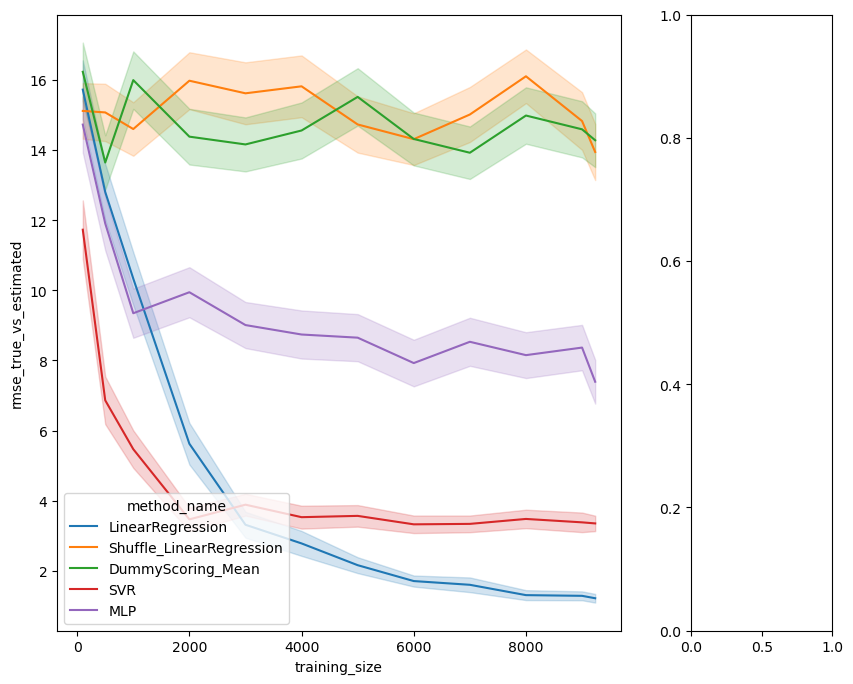

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(10, 8), 
                               gridspec_kw={'width_ratios': [4, 1]})

sns.lineplot(data=df, 
             x='training_size', 
             y='rmse_true_vs_estimated', 
             hue='method_name', 
             errorbar=('se', 1),
             ax=ax1)

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dbf = os.path.join(_FINAL_DFS_DIR, 'optim_ablation.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')
df

,method_name,number,value,euclidean_distance,rmse_true_vs_estimated,ablation_distance,run_type
0,LinearRegression,0,1.001659,28.079715,17.720737,25,ablation
1,LinearRegression,1,0.998253,12.823638,17.720737,25,ablation
2,LinearRegression,2,0.996458,14.093707,17.720737,25,ablation
3,LinearRegression,3,1.001572,8.796211,17.720737,25,ablation
4,LinearRegression,4,1.004591,16.307747,17.720737,25,ablation
...,...,...,...,...,...,...,...
9179995,DummyScoring_Mean,995,1.000000,24.501106,17.711224,0,ablation
9179996,DummyScoring_Mean,996,1.000000,23.908035,17.711224,0,ablation
9179997,DummyScoring_Mean,997,1.000000,25.577454,17.711224,0,ablation
9179998,DummyScoring_Mean,998,1.000000,24.343669,17.711224,0,ablation


In [8]:
# Assuming df is your original dataframe
# Remove Shuffle_LinearRegression and Dummy from control run_type
df_filtered = df[~((df['run_type'] == 'control') & 
                   (df['method_name'].isin(['Shuffle_LinearRegression', 'DummyScoring_Mean'])))]

# Get the last number for each method, ablation distance, and run_type
last_values = df_filtered.groupby(['method_name', 'ablation_distance', 'run_type'])['number'].max().reset_index()
df_last = df_filtered.merge(last_values, on=['method_name', 'ablation_distance', 'run_type', 'number'])

# Create a combined column for method and run_type
df_last['method_run'] = df_last['method_name'] + ' (' + df_last['run_type'] + ')'


Text(0.5, 0, 'N')

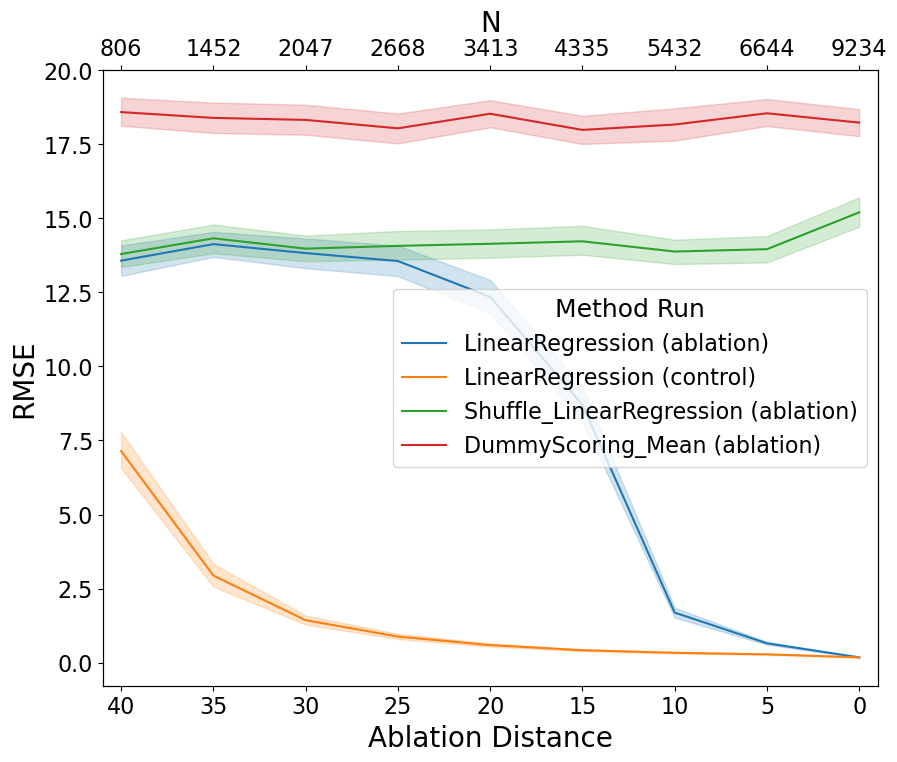

In [9]:
# Create the plot
plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=df_last, x='ablation_distance', y='rmse_true_vs_estimated', 
                  hue='method_run')

# Customize the plot
plt.xlabel('Ablation Distance', fontsize=20)
plt.ylabel('RMSE', fontsize=20)

# Increase font size for tick labels
plt.tick_params(axis='both', which='major', labelsize=16)

# Modify the legend
ax.legend(title='Method Run', fontsize=16, title_fontsize=18, loc='best')

# Create a secondary x-axis for N values
ax2 = ax.twiny()

xlim = [-1, 41]
ax.set_xlim(xlim)
ax2.set_xlim(xlim)

# Define the ablation distance and N value pairs
ablation_distances = [0, 5, 10, 15, 20, 25, 30, 35, 40]
N_values = [9234, 6644, 5432, 4335, 3413, 2668, 2047, 1452, 806]

# Set the tick locations and labels for both axes
ax.set_xticks(ablation_distances)
ax.set_xticklabels(ablation_distances)
ax2.set_xticks(ablation_distances)
ax2.set_xticklabels(N_values)

# Increase font size for tick labels
plt.tick_params(axis='both', which='major', labelsize=16)

# Invert x-axis
ax.invert_xaxis()
ax2.invert_xaxis()

# Label the secondary x-axis
ax2.set_xlabel('N', fontsize=20)